In [16]:
import os
import re
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
os.makedirs("../figures", exist_ok=True)

In [17]:
sns.set_style("ticks")
sns.set_theme(style=None)

plt.rcParams.update({
    'legend.title_fontsize': 8,
    'legend.fontsize': 8,
    'font.size': 8,
    'xtick.labelsize': 6,      # Size of x-axis tick labels
    'ytick.labelsize': 6,
    "axes.labelsize": 8,
    "font.family": "Nimbus Sans",       # or "Arial" / "Helvetica" if you use them
    "mathtext.fontset": "stixsans",   # make mathtext use same family
    "mathtext.default": "regular",      # normal upright font, not italic
    "axes.spines.top": False,
    "axes.spines.right": False,
})

plt.rcParams.update({
    "xtick.major.size": 3,   # default ~3.5–5, lower = shorter
    "xtick.minor.size": 2,
    "ytick.major.size": 3,
    "ytick.minor.size": 2,
})

plt.rcParams['svg.fonttype'] = 'none'

Model short names:

In [18]:
short_names = {
    "Qwen3-Embedding-4B": "Qwen-4B",
    "Qwen3-Embedding-8B": "Qwen-8B",
    "BioLORD-2023": "BioLORD",
    "inf-retriever-v1": "InfRet",
    "all-MiniLM-L12-v2": "MiniLM-L12",
    "all-MiniLM-L6-v2": "MiniLM-L6",
    "pubmedbert-base-embeddings": "PubMedBERT",
    "multi-qa-mpnet-base-dot-v1": "MPNet-QA",
    "sentence-t5-xxl": "T5-XL",
    # ensemble names
    "zsum": "Z-sum",
    "rrf60": "RRF",
    "combsum": "CombSum",
    "fisher": "Fisher",
    "combmnz": "CombMNZ",
    "rra": "RRA",
    "medianrank": "Median rank",
    "meanrank": "Mean rank"
}


# Figure 2

In previous version of this plot, results were poorer because not all ICD codes were available to be retieved, yet were evaluated as if they were. Hence there was a max recall < 1. Now recall can be 1 since those ICD codes were removed.

Take only "difficult" Phecodes, i.e. Phecodes with >10 ICD codes

In [19]:
# Load results and add meta-data
master_metrics_df = pd.read_parquet(
    '/sc/arion/projects/va-biobank/jamie/phecoder/results/phecodeX/metrics.parquet'
)
phecode_info = pd.read_parquet(
    '/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_info.parquet'
)
master_metrics_df = master_metrics_df.merge(phecode_info, on='phecode', how='left')
master_metrics_df["category_abbrev"] = master_metrics_df["phecode"].str.split("_").str[0]

# Normalize model names
master_metrics_df["model"] = master_metrics_df["model"].str.split("/").str[-1]

# --- add ensemble flag (True/False) ---
master_metrics_df["is_ensemble"] = master_metrics_df["model"].str.startswith("ens", na=False)

# --- clean model names (remove any prefix before ':') ---
master_metrics_df["model"] = master_metrics_df["model"].str.split(":").str[-1]

# --- filter main results ---
metrics_df = master_metrics_df.query("n_gold_pos > 10 and model != 'gte-Qwen2-7B-instruct'")

# apply shortnames
metrics_df.loc[:, 'model'] = metrics_df['model'].replace(short_names)

Evaluation of individual LLMs:

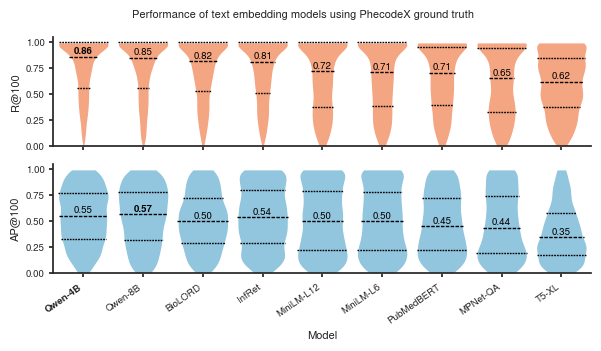

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metric_dict = {
    "Recall": "R@k",
    "AP": "AP@k"
}

# Define which (metric, k) pairs to plot
plots = [
    ("Recall", 100),
    ("AP", 100),
]

# Sort
sort_by = "Recall@100"  # e.g. "AP@20", "Recall@100"
metric_sort, k_sort = sort_by.split("@")
k_sort = int(k_sort)
sort_col = metric_dict[metric_sort]
order_global = (
    metrics_df[(metrics_df["k"] == k_sort) & (~metrics_df["is_ensemble"])]
    .groupby("model")[sort_col]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)
# ---------------------------------------------------------------------
fig, axes = plt.subplots(len(plots), 1, figsize=(6, 3.5), sharex=True, sharey=True)

for ax, (metric, k) in zip(axes, plots):

    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = rf"{metric_caps}@{k}"

    metric_df_temp = metrics_df[(metrics_df["k"] == k) & (~metrics_df["is_ensemble"])]

    # colour by metric (colorblind safe https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3)
    if metric=='AP':
        color='#92c5de'
    elif metric=='Recall':
        color='#f4a582'

    sns.violinplot(
        data=metric_df_temp,
        x="model",
        y=metric_dict[metric],
        order=order_global,
        inner="quartile",
        cut=0,
        width=0.85,
        density_norm="count",
        ax=ax,
        color=color,
        linewidth=1,
        edgecolor=None,
        saturation=1,
        inner_kws={"color": "black"}
    )

    # medians
    medians = metric_df_temp.groupby("model")[metric_dict[metric]].median().reindex(order_global)
    max_model = medians.idxmax()   # model with largest median
    if metric=='Recall':
        max_model_recall = max_model

    for i, model in enumerate(order_global):
        y_med = medians.loc[model]
        ax.annotate(
            f"{y_med:.2f}",
            xy=(i, y_med),
            xytext=(0, 3.5),
            textcoords="offset points",
            ha="center",
            va="center",
            fontsize=7,
            fontweight="bold" if model == max_model else "normal",
            color="black",
            # bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="None", lw=0.2, alpha=0.8),
            zorder=10,
            clip_on=False,
        )

    ax.set_ylim(0.0, 1.05)
    ax.set_xlabel("Model", fontsize=8)
    ax.set_ylabel(metric_k, fontsize=8)
    plt.xticks(rotation=35, ha="right", fontsize=7)
    ax.tick_params(axis="y", labelsize=7)

for label in ax.get_xticklabels():
    if label.get_text() == max_model_recall:
        label.set_fontweight("bold")

fig.suptitle("Performance of text embedding models using PhecodeX ground truth", fontsize=8)

plt.tight_layout()

# save 
for extension in ['png', 'svg']:
    plt.savefig(f"../figures/fig2a.{extension}", dpi=300)

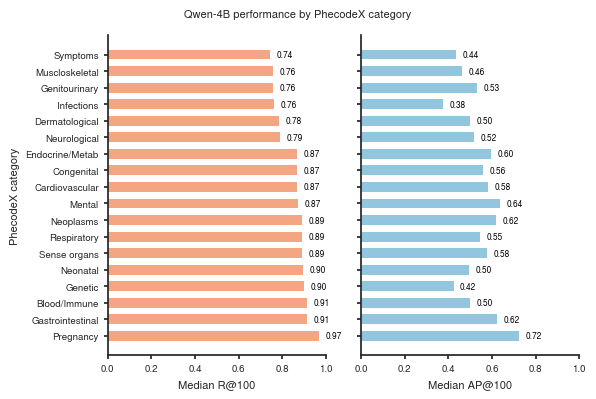

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric_dict = {"Recall": "R@k", "AP": "AP@k"}

best_model = "Qwen-4B"
metrics_best = metrics_df[metrics_df["model"] == best_model]

# --- added: fixed category order by Recall@100 ---
order_metric, order_k = "Recall", 100
order_col = metric_dict[order_metric]
cat_order = (
    metrics_best[metrics_best["k"] == order_k]
    .groupby("category")[order_col]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

plots = [
    ("Recall", 100),
    ("AP", 100),
]

fig, axes = plt.subplots(1, len(plots), figsize=(6, 4), sharey=True)
axes = axes.flatten()

for i, (ax, (metric, k)) in enumerate(zip(axes, plots)):

    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = f"Median {metric_caps}@{k}"
    
    df_temp = metrics_best[metrics_best["k"] == k]

    # --- changed: compute medians then reindex to cat_order ---
    medians = df_temp.groupby("category")[metric_dict[metric]].median()
    medians = medians.reindex(cat_order)
    categories = medians.index.tolist()
    values = medians.values

    # bar color
    color = "#92c5de" if metric == "AP" else "#f4a582"

    # horizontal barplot
    ax.barh(categories, values,
            color=color, edgecolor='none',
            height=0.6)

    # annotate bars with values
    for y, val in zip(categories, values):
        ax.text(val + 0.03, y, f"{val:.2f}",
                va="center", ha="left", fontsize=6, color="black")

    # axis labels
    ax.set_xlim(0, 1)
    ax.set_xlabel(metric_k, fontsize=8)  # <-- removed stray 'm'
    if i==0:
        ax.set_ylabel(f'PhecodeX category', fontsize=8)
    ax.tick_params(axis="y", labelsize=7)
    ax.tick_params(axis="x", labelsize=7)

fig.suptitle("Qwen-4B performance by PhecodeX category", fontsize=8)

# layout
plt.tight_layout()

# save
for extension in ['png', 'svg']:
    plt.savefig(f"../figures/fig2b.{extension}", dpi=300, bbox_inches='tight')


# Figure 3

In [70]:
from phecoder.utils import load_results

results_dir = "/sc/arion/projects/va-biobank/jamie/phecoder/results/phecodeX"
phecode_ground_truth = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_icd_pairs.parquet')

# used to select Phecode size > 10 from earlier figure
phecodes = metrics_df['phecode'].unique()

sim_df = load_results(dir=results_dir, phecode_ground_truth=phecode_ground_truth, include_ensembles=False)
sim_df["model"] = sim_df["model"].str.split("/").str[-1]

# apply shortnames
sim_df.loc[:, 'model'] = sim_df['model'].replace(short_names)

/sc/arion/projects/va-biobank/jamie/phecoder/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Function to compute median Jaccard Index across Phecodes

In [71]:
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

def compare_models_jaccard(sim_df: pd.DataFrame, phecodes=None, K: int = 1000):
    """
    Compute pairwise Jaccard@K overlap between models across phecodes.

    Parameters
    ----------
    sim_df : pd.DataFrame
        Long-format similarity results (columns: model, phecode, icd_code, rank)
    phecodes : list[str], optional
        Restrict to these phecodes.
    K : int
        Top-K cutoff for overlap computation.

    Returns
    -------
    pd.DataFrame
        Pairwise Jaccard@K scores averaged across phecodes.
    """
    df = sim_df.copy()
    if phecodes is not None:
        df = df[df["phecode"].isin(phecodes)]
    df = df[df["rank"] <= K]

    models = sorted(df["model"].unique())
    pairs = list(combinations(models, 2))
    out = []

    for phe, sub in df.groupby("phecode", sort=False):
        lists = {
            m: set(sub.loc[sub["model"] == m, "icd_code"])
            for m in models
        }
        for a, b in pairs:
            la, lb = lists[a], lists[b]
            if not la or not lb:
                continue
            jac = len(la & lb) / len(la | lb)
            out.append({
                "phecode": phe,
                "model_a": a,
                "model_b": b,
                f"Jaccard@{K}": jac,
            })
    df_out = pd.DataFrame(out)
    return (
        df_out
        .groupby(["model_a", "model_b"], as_index=False)
        [f"Jaccard@{K}"].median()
        .pivot(index="model_a", columns="model_b", values=f"Jaccard@{K}")
    )


In [72]:
K = 100

# --- Compute symmetric matrices ---
jaccard_known = compare_models_jaccard(
    sim_df[sim_df["is_known"] == 1], phecodes=phecodes, K=K
)
jaccard_novel = compare_models_jaccard(
    sim_df[sim_df["is_known"] == 0], phecodes=phecodes, K=K
)

known = jaccard_known.combine_first(jaccard_known.T)
novel = jaccard_novel.combine_first(jaccard_novel.T)
np.fill_diagonal(known.values, np.nan)  # blank out diagonal
np.fill_diagonal(novel.values, np.nan)

Below, models are grouped based on their average retrieval overlap across both validated and novel ICD spaces.

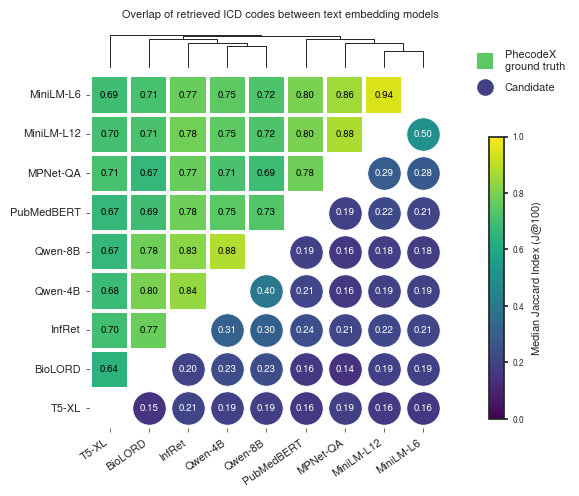

In [76]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns

# --- clustering on blended ---
M = 0.5 * (known.fillna(1.0) + novel.fillna(1.0))
np.fill_diagonal(M.values, 1.0)
D = (1.0 - M).clip(0, 1)
Z = linkage(squareform(D.values, checks=True), method="average")

# Use the *exact* leaf order that the dendrogram uses
order_info = dendrogram(Z, no_plot=True)
leaf_idx = order_info["leaves"]
order = M.index.to_numpy()[leaf_idx].tolist()

# Reorder matrices
known = known.loc[order, order]
novel = novel.loc[order, order]
models = order
n = len(models)

# --- Figure: one main axis for heatmap; dendrogram as an inset tied to it ---
fig, ax = plt.subplots(figsize=(5.5, 5.5), constrained_layout=True)

# Masks
mask_upper = np.tril(np.ones_like(known, dtype=bool))
mask_lower = np.triu(np.ones_like(known, dtype=bool))

# Lower triangle (squares)
sns.heatmap(
    known, mask=mask_lower, cmap="viridis", vmin=0, vmax=1,
    square=True, linewidths=1.5, cbar=False,
    annot=True, annot_kws={"size": 7, "color": "black"},
    fmt=".2f", ax=ax
)

# Upper triangle (circles)
for i in range(n):
    for j in range(i + 1, n):
        val = novel.iloc[i, j]
        if np.isfinite(val):
            ax.scatter(j + 0.5, i + 0.5, s=575,
                       facecolor=plt.cm.viridis(val),
                       edgecolor="white", linewidth=0.5)
            ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                    ha="center", va="center", fontsize=7, color="white")

# ---- TOP DENDROGRAM aligned to heatmap data area ----
# Make an inset axis that sits directly above the heatmap's DATA region
ax_dend = ax.inset_axes([0.0, 1.02, 1.0, 0.1], transform=ax.transAxes)  # [left, bottom, width, height] in axes coords

# Get dendrogram coordinates without plotting
ddata = dendrogram(Z, no_plot=True, color_threshold=0, above_threshold_color="dimgray")

# Map SciPy's leaf centers [5,15,25,...] to our heatmap centers [0.5, 1.5, ..., n-0.5]
x_orig_centers = np.linspace(5, 5 + 10*(n-1), n)
x_target_centers = np.arange(n) + 0.5
scale = (x_target_centers[-1] - x_target_centers[0]) / (x_orig_centers[-1] - x_orig_centers[0])
shift = x_target_centers[0] - x_orig_centers[0] * scale
icoord_scaled = [[x * scale + shift for x in ico] for ico in ddata["icoord"]]

# Draw dendrogram lines in the inset axis
for ico, dco in zip(icoord_scaled, ddata["dcoord"]):
    ax_dend.plot(ico, dco, linewidth=0.6, color='black')

ax_dend.set_xlim(0, n)     # share the same data span
ax_dend.axis("off")        # hide ticks/spines so only branches remain

# --- Colorbar ---
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(0, 1))
cbar = fig.colorbar(sm, ax=ax, anchor=(0, 0.4), fraction=0.04, pad=-0.15)
cbar.set_label(r"Median Jaccard Index ($J@100$)", fontsize=8)

# --- Labels & styling (unchanged) ---
ax.set_xticks(np.arange(n) + 0.5)
ax.set_yticks(np.arange(n) + 0.5)
ax.tick_params(length=3, width=0.5)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_xticklabels(models, rotation=35, ha="right")
ax.set_yticklabels(models, rotation=0)
ax.invert_yaxis()

# --- Legend (unchanged) ---
mean_known = np.nanmedian(known.values)
mean_novel = np.nanmedian(novel.values)
handles = [
    plt.Line2D([], [], marker='s', linestyle='None',
               markerfacecolor=plt.cm.viridis(mean_known), markeredgewidth=0,
               markersize=12, label='PhecodeX \nground truth'),
    plt.Line2D([], [], marker='o', linestyle='None',
               markerfacecolor=plt.cm.viridis(mean_novel), markeredgewidth=0,
               markersize=12, label='Candidate')
]
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.375, 1.1),
          frameon=False, labelspacing=1.0, fontsize=8)

fig.suptitle(
    "Overlap of retrieved ICD codes between text embedding models",
    y=0.94,
    fontsize=8
)


# save 
for extension in ['png', 'svg']:
    fig.savefig(f"../figures/fig3.{extension}", bbox_inches="tight", dpi=300)


# Figure 4

/tmp/ipykernel_3195999/1804923154.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bottom.set_xticklabels(new_labels, rotation=35, ha="right", fontsize=8)


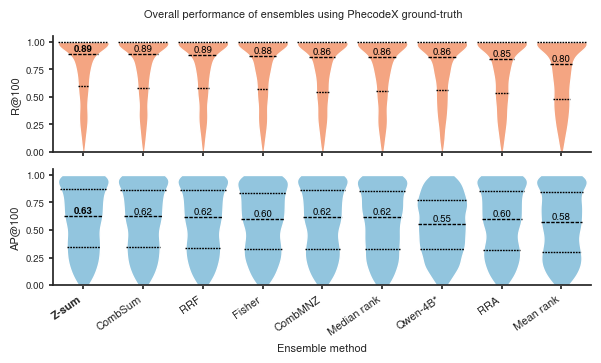

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

extra_models = ['Qwen-4B']

metric_dict = {
    "Recall": "R@k",
    "AP": "AP@k"
}

# Define which (metric, k) pairs to plot
plots = [
    ("Recall", 100),
    ("AP", 100),
]

# Sort
sort_by = "Recall@100"  # e.g. "AP@20", "Recall@100"
metric_sort, k_sort = sort_by.split("@")
k_sort = int(k_sort)
sort_col = metric_dict[metric_sort]
order_global = (
    metrics_df[(metrics_df["k"] == k_sort) & (metrics_df["is_ensemble"] | metrics_df["model"].isin(extra_models))]
    .groupby("model")[sort_col]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

# ---------------------------------------------------------------------
fig, axes = plt.subplots(len(plots), 1, figsize=(6, 3.5), sharex=True, sharey=True)

for ax, (metric, k) in zip(axes, plots):

    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = rf"{metric_caps}@{k}"

    metric_df_temp = metrics_df[(metrics_df["k"] == k) & (metrics_df["is_ensemble"] | metrics_df["model"].isin(extra_models))]

    # colour by metric (colorblind safe https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3)
    if metric=='AP':
        color='#92c5de'
    elif metric=='Recall':
        color='#f4a582'

    sns.violinplot(
        data=metric_df_temp,
        x="model",
        y=metric_dict[metric],
        order=order_global,
        inner="quartile",
        cut=0,
        width=0.85,
        density_norm="count",
        ax=ax,
        color=color,
        linewidth=1,
        edgecolor=None,
        saturation=1,
        inner_kws={"color": "black"}
    )

    # medians
    medians = metric_df_temp.groupby("model")[metric_dict[metric]].median().reindex(order_global)
    max_model = medians.idxmax()   # model with largest median
    for i, model in enumerate(order_global):
        y_med = medians.loc[model]
        ax.annotate(
            f"{y_med:.2f}",
            xy=(i, y_med),
            xytext=(0, 3.5),
            textcoords="offset points",
            ha="center",
            va="center",
            fontsize=7,
            fontweight="bold" if model == max_model else "normal",
            color="black",
            # bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="None", lw=0.2, alpha=0.8),
            zorder=10,
            clip_on=False,
        )

    ax.set_ylim(0.0, 1.05)
    ax.set_xlabel("Ensemble method", fontsize=8)
    ax.set_ylabel(metric_k, fontsize=8)
    plt.xticks(rotation=25, ha="right", fontsize=7)
    ax.tick_params(axis="y", labelsize=7)

for label in ax.get_xticklabels():
    if label.get_text() == max_model:
        label.set_fontweight("bold")


fig.suptitle("Overall performance of ensembles using PhecodeX ground-truth", fontsize=8)

plt.tight_layout()

ax_bottom = axes[-1]  # only bottom plot shows x-labels
labels = [t.get_text() for t in ax_bottom.get_xticklabels()]
new_labels = [lbl + "*" if lbl in extra_models else lbl for lbl in labels]
ax_bottom.set_xticklabels(new_labels, rotation=35, ha="right", fontsize=8)

for extension in ['png', 'svg']:
    plt.savefig(f"../figures/fig4a.{extension}", dpi=300, bbox_inches='tight')

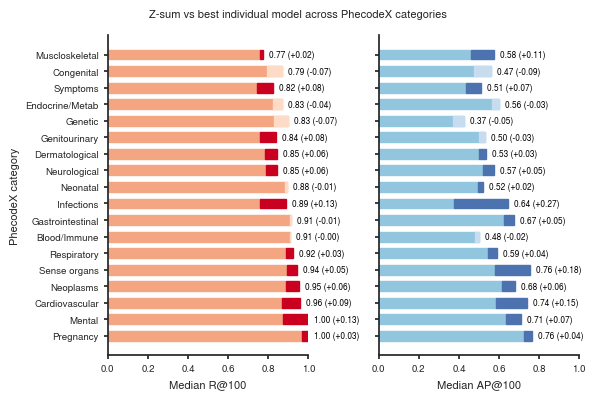

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric_dict = {"Recall": "R@k", "AP": "AP@k"}

base_model = "Qwen-4B"
ens_model  = "Z-sum"  # adjust if your zsum label differs

df_base = metrics_df[metrics_df["model"] == base_model].copy()
df_ens  = metrics_df[metrics_df["model"].str.contains(ens_model, case=False, na=False)].copy()

# --- NEW: fixed category order based on zsum's Recall@100 ---
order_metric, order_k = "Recall", 100
order_col = metric_dict[order_metric]
cat_order = (
    df_ens[df_ens["k"] == order_k]
    .groupby("category")[order_col]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

plots = [
    ("Recall", 100),
    ("AP", 100),
]

fig, axes = plt.subplots(1, len(plots), figsize=(6, 4), sharey=True)
axes = axes.flatten()

for i, (ax, (metric, k)) in enumerate(zip(axes, plots)):

    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = f"Median {metric_caps}@{k}"

    df_base_k = df_base[df_base["k"] == k]
    df_ens_k  = df_ens[df_ens["k"] == k]

    med_base = df_base_k.groupby("category")[metric_dict[metric]].median()
    med_ens  = df_ens_k.groupby("category")[metric_dict[metric]].median()

    # align categories and reindex to fixed order from zsum Recall@100
    common = [c for c in cat_order if c in med_base.index and c in med_ens.index]
    med_base = med_base.reindex(common)
    med_ens  = med_ens.reindex(common)

    # delta
    delta = med_ens - med_base

    # base color
    base_color = "#92c5de" if metric == "AP" else "#f4a582"
    darker     = "#4c72b0" if metric == "AP" else "#ca0020"
    lighter    = "#c7dcef" if metric == "AP" else "#fddbc7"

    # draw base bars
    ax.barh(common, med_base,
            color=base_color, edgecolor=base_color, #linewidth=0.7,
            height=0.6, label="Base")

    # overlay only the delta segment
    for y, base_val, d in zip(common, med_base, delta):
        new_val = base_val + d

        delta_txt = f" ({d:+.2f})"
        label_txt = f"{new_val:.2f}{delta_txt}"

        if d > 0:
            ax.barh(y, d, left=base_val, color=darker, height=0.6, edgecolor=darker)
            ax.text(new_val + 0.03, y, label_txt,
                    va="center", ha="left", fontsize=6, color="black")

        elif d < 0:
            ax.barh(y, abs(d), left=base_val + d, color=lighter, height=0.6, edgecolor=lighter)
            ax.text(base_val + 0.03, y, label_txt,
                    va="center", ha="left", fontsize=6, color="black")

        # new_val = base_val + d  # final ensemble value for annotation
        # if d > 0:  # improvement: extend bar to the right
        #     ax.barh(y, d, left=base_val, color=darker, height=0.6, edgecolor=darker)
        #     ax.text(new_val + 0.03, y, f"{new_val:.2f}",
        #             va="center", ha="left", fontsize=6, color="black")
        # elif d < 0:  # worse: overlay lighter segment (shorter bar)
        #     ax.barh(y, abs(d), left=base_val + d, color=lighter, height=0.6, edgecolor=lighter)
        #     ax.text(base_val + 0.03, y, f"{new_val:.2f}",
        #             va="center", ha="left", fontsize=6, color="black")

    # axes setup
    ax.set_xlim(0, 1)
    ax.set_xlabel(metric_k, fontsize=8)
    if i == 0:
        ax.set_ylabel("PhecodeX category", fontsize=8)
    ax.tick_params(axis="y", labelsize=7)
    ax.tick_params(axis="x", labelsize=7)

fig.suptitle("Z-sum vs best individual model across PhecodeX categories", fontsize=8)

plt.tight_layout()

for ext in ['png', 'svg']:
    plt.savefig(f"../figures/fig4b.{ext}", dpi=300, bbox_inches='tight')


# Figure 5

In [20]:
all_sets = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/sets_tidy.csv')
all_sizes = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/set_sizes.csv')
set_descriptions = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/set_descriptions.csv')
merged = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/merged_phecoder_output.csv', low_memory=False)
phecode_info = pd.read_parquet(
    '/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_info.parquet'
)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

trunc = merged[(merged["retrieved"] == 1) & (merged["model"] == "zsum")].copy()

def compute_ppv(df, condition, label):
    df = df.copy()
    df["is_rel"] = df.eval(condition).astype(int)

    ppv_list = []
    for phecode, sub in df.groupby("phecode"):
        sub = sub.sort_values("rank")
        total = 0
        rel = 0
        for _, row in sub.iterrows():
            total += 1
            rel += row["is_rel"]
            ppv_list.append((phecode, total, rel / total))

    ppv_df = pd.DataFrame(ppv_list, columns=["phecode", "rank", "PPV"])
    ppv_df["Type"] = label
    return ppv_df

# --- Function: cumulative new@k ---------------------------------------
def compute_newk(df, condition, label):
    """
    Compute cumulative number of *new* ICDs (not in PheCodeX)
    satisfying a relevance condition as a function of rank k.
    """
    df = df.copy()
    df["is_rel"] = df.eval(condition).astype(int)
    df["is_new"] = (df["is_known"] == 0).astype(int)  # not in PheCodeX

    records = []
    for phecode, sub in df.groupby("phecode"):
        sub = sub.sort_values("rank")
        total_new = 0
        for _, row in sub.iterrows():
            total_new += (row["is_new"] & row["is_rel"])
            records.append((phecode, row["rank"], total_new))
    out = pd.DataFrame(records, columns=["phecode", "rank", "new"])
    out["Type"] = label
    return out

def compute_newk_mask(df, rel_condition, mask_col, label):
    df = df.copy()
    df["is_rel"] = df.eval(rel_condition).astype(int)
    df["is_mask"] = df[mask_col].astype(int)

    records = []
    for phecode, sub in df.groupby("phecode"):
        sub = sub.sort_values("rank")
        total = 0
        for _, row in sub.iterrows():
            total += int(row["is_mask"] & row["is_rel"])
            records.append((phecode, row["rank"], total))
    out = pd.DataFrame(records, columns=["phecode", "rank", "new"])
    out["Type"] = label
    return out

# Compute cumulative PPVs
ppv_known = compute_ppv(trunc, "is_known == 1", "PhecodeX")
ppv_strict = compute_ppv(trunc, "relevant == 2", "Reviewer (strict)")
ppv_extended = compute_ppv(trunc, "relevant in [1,2]", "Reviewer (extended)")

ppv_all = pd.concat([ppv_known, ppv_strict, ppv_extended], ignore_index=True)

# --- Compute curves ----------------------------------------------------
new_r2 = compute_newk(trunc, "relevant == 2", "Reviewer (strict)")# r"$R_2$")
new_r12 = compute_newk(trunc, "relevant in [1,2]", "Reviewer (extended)")
new_all = pd.concat([new_r2, new_r12], ignore_index=True)

# Non-trivial (R2 only = strict, R1+R2 = extended)
new_nt_r2  = compute_newk_mask(trunc, "relevant == 2",     "is_nontrivial_new", "Reviewer (strict)")
new_nt_r12 = compute_newk_mask(trunc, "relevant in [1,2]", "is_nontrivial_new", "Reviewer (extended)")

# Combined non-trivial new ICD curves
new_all_nt = pd.concat([new_nt_r2, new_nt_r12], ignore_index=True)

In [28]:
columns_to_keep = ['model', 'phecode', 'phecode_string', 'icd_code', 'icd_string', 'score',
       'rank', 'n_icd', 'created_at', 'is_known', 'flag']
new = trunc[columns_to_keep]

In [30]:
new.to_excel('output.xlsx', index=False)

In [67]:
trunc[(trunc['phecode']=='MB_287.1')&(trunc['is_known']==0)&(trunc['relevant'].isin([2]))].sort_values('rank')

,model,phecode,phecode_string,icd_code,icd_string,score,rank,n_icd,n_phecodes,created_at,is_known,flag,relevant,comments,cutoff_rank,retrieved,is_known_parent,is_nontrivial_new
2201870,zsum,MB_287.1,Schizophrenia,F20.81,Schizophreniform disorder,65.691430,6,67632,6,2025-10-30T13:42:16Z,0,10,2.0,NaN,113,1,1,0
2054620,zsum,MB_287.1,Schizophrenia,295.42,"SCHIZOPHRENIFORM DISORDER, CHRONIC",57.635396,13,67632,6,2025-10-30T13:42:16Z,0,9,2.0,NaN,113,1,1,0
2054600,zsum,MB_287.1,Schizophrenia,295.40,"SCHIZOPHRENIFORM DISORDER, UNSPECIFIED",56.624887,20,67632,6,2025-10-30T13:42:16Z,0,9,2.0,NaN,113,1,1,0
2055640,zsum,MB_287.1,Schizophrenia,298.9,UNSPECIFIED PSYCHOSIS,56.367117,21,67632,6,2025-10-30T13:42:16Z,0,9,2.0,NaN,113,1,1,0
2054800,zsum,MB_287.1,Schizophrenia,295.72,"SCHIZOAFFECTIVE DISORDER, CHRONIC",56.007006,24,67632,6,2025-10-30T13:42:16Z,0,9,2.0,NaN,113,1,1,0
2201920,zsum,MB_287.1,Schizophrenia,F23,Brief psychotic disorder,54.190711,34,67632,6,2025-10-30T13:42:16Z,0,10,2.0,NaN,113,1,1,0
2201970,zsum,MB_287.1,Schizophrenia,F25.9,"Schizoaffective disorder, unspecified",53.650920,39,67632,6,2025-10-30T13:42:16Z,0,10,2.0,NaN,113,1,1,0
2201960,zsum,MB_287.1,Schizophrenia,F25.8,Other schizoaffective disorders,53.649220,40,67632,6,2025-10-30T13:42:16Z,0,10,2.0,NaN,113,1,1,0
2054780,zsum,MB_287.1,Schizophrenia,295.70,"SCHIZOAFFECTIVE DISORDER, UNSPECIFIED",53.565571,43,67632,6,2025-10-30T13:42:16Z,0,9,2.0,NaN,113,1,1,0
2054610,zsum,MB_287.1,Schizophrenia,295.41,"SCHIZOPHRENIFORM DISORDER, SUBCHRONIC",53.214504,45,67632,6,2025-10-30T13:42:16Z,0,9,2.0,NaN,113,1,1,0


In [61]:
ppv_strict[ppv_strict['phecode']=='MB_280.2']

,phecode,rank,PPV,Type
101,MB_280.2,1,1.000000,Reviewer (strict)
102,MB_280.2,2,1.000000,Reviewer (strict)
103,MB_280.2,3,1.000000,Reviewer (strict)
104,MB_280.2,4,1.000000,Reviewer (strict)
105,MB_280.2,5,1.000000,Reviewer (strict)
...,...,...,...,...
211,MB_280.2,111,0.657658,Reviewer (strict)
212,MB_280.2,112,0.651786,Reviewer (strict)
213,MB_280.2,113,0.654867,Reviewer (strict)
214,MB_280.2,114,0.649123,Reviewer (strict)


In [62]:
phecodes

['MB_280.11', 'MB_280.2', 'MB_286.1', 'MB_287.1', 'MB_293', 'MB_296']

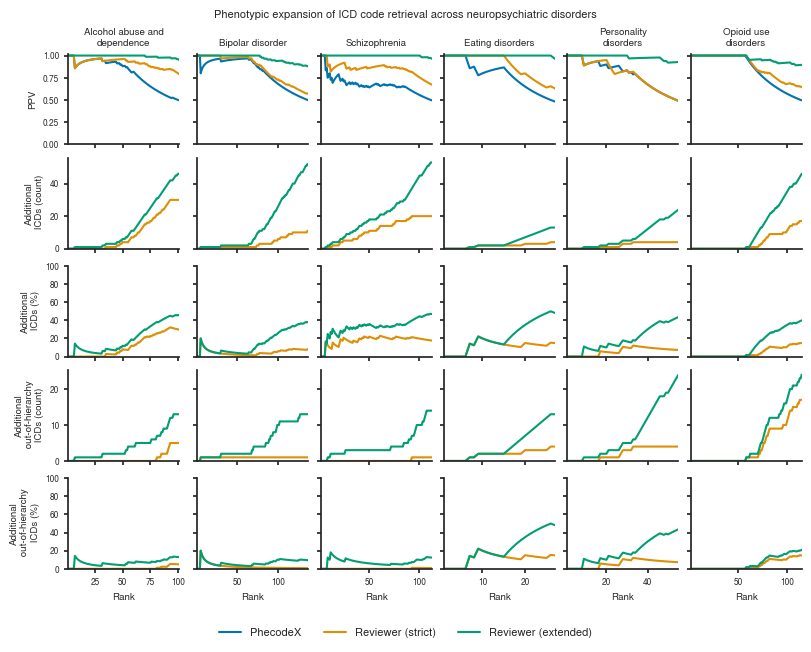

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import textwrap
from matplotlib.ticker import EngFormatter

# ---------- STYLE PARAMS ----------
formatter = EngFormatter(sep="")
base_palette = sns.color_palette("colorblind")

ppv_palette = {
    "PhecodeX": base_palette[0],
    "Reviewer (strict)": base_palette[1],
    "Reviewer (extended)": base_palette[2],
}

new_palette = {
    "Reviewer (strict)": base_palette[1],
    "Reviewer (extended)": base_palette[2],
}

LINE_WIDTH = 1.5

# ---------- PREPARE FIGURE ----------
phecodes = ['MB_280.11', 'MB_286.1', 'MB_287.1', 'MB_293', 'MB_296', 'MB_280.2']#sorted(ppv_all["phecode"].unique())
ncol = len(phecodes)

fig, axes = plt.subplots(
    nrows=5,
    ncols=ncol,
    figsize=(8, 6),
    constrained_layout=True,
    sharex="col",
    sharey="row"
)

axes = np.atleast_2d(axes)

# global maxes for counts
max_new = new_all["new"].max()
max_nt  = new_all_nt["new"].max()

# ---------- MAIN LOOP ----------
for j, phe in enumerate(phecodes):

    phe_str = phecode_info.loc[phecode_info["phecode"] == phe, "phecode_string"].squeeze()
    title_text = "\n".join(textwrap.wrap(str(phe_str), 18))

    # --- Row 1: PPV ---
    ax = axes[0, j]
    sub_ppv = ppv_all[ppv_all["phecode"] == phe]

    sns.lineplot(
        data=sub_ppv,
        x="rank", y="PPV", hue="Type",
        ax=ax,
        palette=ppv_palette,
        linewidth=LINE_WIDTH,
        legend=(j == 0)
    )

    ax.set_title(title_text, fontsize=7)
    ax.set_ylim(0, 1.02)
    ax.set_xlim(1, sub_ppv["rank"].max())
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%d"))

    if j == 0:
        ax.set_ylabel("PPV", fontsize=7)
        ax.tick_params(axis="y", labelleft=True)
    else:
        ax.set_ylabel("")
        ax.tick_params(axis="y", labelleft=False)

    # --- Prepare novelty data once per phecode ---
    sub_new = new_all[new_all["phecode"] == phe].copy()
    sub_new["pct"] = 100 * sub_new["new"] / sub_new["rank"]

    sub_nt = new_all_nt[new_all_nt["phecode"] == phe].copy()
    sub_nt["pct"] = 100 * sub_nt["new"] / sub_nt["rank"]

    # --- Row 2: Novel COUNT ---
    ax2 = axes[1, j]
    sns.lineplot(
        data=sub_new,
        x="rank", y="new", hue="Type",
        ax=ax2, palette=new_palette,
        linewidth=LINE_WIDTH,
        legend=False
    )
    ax2.set_ylim(0, max_new * 1.05)

    if j == 0:
        ax2.set_ylabel("Additional\n ICDs (count)", fontsize=7)
        ax2.tick_params(axis="y", labelleft=True)
    else:
        ax2.set_ylabel("")
        ax2.tick_params(axis="y", labelleft=False)

    # --- Row 3: Novel PERCENT ---
    ax3 = axes[2, j]
    sns.lineplot(
        data=sub_new,
        x="rank", y="pct", hue="Type",
        ax=ax3, palette=new_palette,
        linewidth=LINE_WIDTH,
        legend=False
    )
    ax3.set_ylim(0, 100)

    if j == 0:
        ax3.set_ylabel("Additional\n ICDs (%)", fontsize=7)
        ax3.tick_params(axis="y", labelleft=True)
    else:
        ax3.set_ylabel("")
        ax3.tick_params(axis="y", labelleft=False)

    # --- Row 4: Hierarchy-novel COUNT ---
    ax4 = axes[3, j]
    sns.lineplot(
        data=sub_nt,
        x="rank", y="new", hue="Type",
        ax=ax4, palette=new_palette,
        linewidth=LINE_WIDTH,
        legend=False
    )
    ax4.set_ylim(0, max_nt * 1.05)

    if j == 0:
        ax4.set_ylabel("Additional\n out-of-hierarchy\n ICDs (count)", fontsize=7)
        ax4.tick_params(axis="y", labelleft=True)
    else:
        ax4.set_ylabel("")
        ax4.tick_params(axis="y", labelleft=False)

    # --- Row 5: Hierarchy-novel PERCENT ---
    ax5 = axes[4, j]
    sns.lineplot(
        data=sub_nt,
        x="rank", y="pct", hue="Type",
        ax=ax5, palette=new_palette,
        linewidth=LINE_WIDTH,
        legend=False
    )
    ax5.set_ylim(0, 100)

    if j == 0:
        ax5.set_ylabel("Additional\n out-of-hierarchy\n ICDs (%)", fontsize=7)
        ax5.tick_params(axis="y", labelleft=True)
    else:
        ax5.set_ylabel("")
        ax5.tick_params(axis="y", labelleft=False)

    # x-axis label only on bottom row
    ax5.set_xlabel("Rank", fontsize=7)

# ----- GLOBAL LEGEND -----
handles, labels = axes[0, 0].get_legend_handles_labels()
if axes[0, 0].get_legend():
    axes[0, 0].get_legend().remove()

fig.legend(
    handles, labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.07),
    ncol=3,
    frameon=False,
    fontsize=8
)

fig.suptitle('Phenotypic expansion of ICD code retrieval across neuropsychiatric disorders', fontsize=8)

# ---------- SAVE ----------
for ext in ["png", "svg"]:
    fig.savefig(f"../figures/fig5.{ext}", dpi=300, bbox_inches="tight")


In [27]:
sub_new[sub_new['Type']=='Reviewer (strict)']

,phecode,rank,new,Type,pct
101,MB_280.2,1,0,Reviewer (strict),0.000000
102,MB_280.2,2,0,Reviewer (strict),0.000000
103,MB_280.2,3,0,Reviewer (strict),0.000000
104,MB_280.2,4,0,Reviewer (strict),0.000000
105,MB_280.2,5,0,Reviewer (strict),0.000000
...,...,...,...,...,...
211,MB_280.2,111,16,Reviewer (strict),14.414414
212,MB_280.2,112,16,Reviewer (strict),14.285714
213,MB_280.2,113,17,Reviewer (strict),15.044248
214,MB_280.2,114,17,Reviewer (strict),14.912281


# Figure 6

In [43]:
counts_df = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/data/raw/david/3.MiniStatsbySet.txt', sep="|")
counts_df = counts_df[(counts_df['Model']=='zsum')&(counts_df['DemoValue']!='ASN')]
phecode_info = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_info.parquet')

In [44]:
# ---- BUILD "All" FROM Sex ONLY (M + F) ----
sex_df = counts_df[counts_df["Demo"] == "Sex"].copy()

all_demo = (
    sex_df.groupby(["Model", "Phecode", "Set", "DxCount"], as_index=False)
    .agg({
        "Total": "sum",   # M + F
        "CStat": "sum",   # M + F
    })
)

all_demo["Demo"] = "All"
all_demo["DemoValue"] = "All"

# Append back
counts_df = pd.concat([counts_df, all_demo], ignore_index=True)

# ---- Build one df per demographic type (as you had) ----
demo_groups = counts_df['Demo'].dropna().unique()
demo_dfs = {}

for demo in demo_groups:
    df_sub = counts_df[counts_df["Demo"] == demo].copy()
    df_sub.rename(columns={"DemoValue": demo}, inplace=True)
    demo_dfs[demo] = df_sub

In [45]:
# Build one df per demographic type
demo_groups = counts_df['Demo'].dropna().unique()
demo_dfs = {}

for demo in demo_groups:
    df_sub = counts_df[counts_df["Demo"] == demo].copy()
    
    # Ensure DemoValue becomes a column named after the demographic (e.g. "Hare")
    df_sub.rename(columns={"DemoValue": demo}, inplace=True)

    demo_dfs[demo] = df_sub

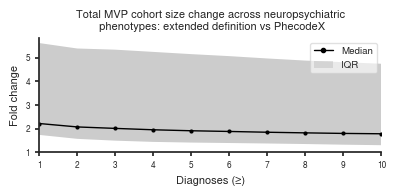

In [46]:
from matplotlib.ticker import EngFormatter
import matplotlib.lines as mlines
from matplotlib.patches import Patch

# ---------- PARAMS ----------
SET_X        = "X"
SET_EXTENDED = "R2_or_R1"
ROW_DEMOS = ["Hare", "Sex"]
formatter = EngFormatter(sep="")

# choose reference demo for ordering
some_demo = ROW_DEMOS[0]
phecodes  = sorted(demo_dfs[some_demo]["Phecode"].unique())
dx_values = sorted(demo_dfs[some_demo]["DxCount"].unique())[:10]

# ============================================================
#   BUILD LONG-FORMAT DATAFRAME (one row per fold-change)
# ============================================================
rows = []

for demo_choice in ROW_DEMOS:
    df_demo = demo_dfs[demo_choice].copy()
    key_col = demo_choice

    for phe in phecodes:
        sub = df_demo[df_demo["Phecode"] == phe]

        levels = sorted(sub[key_col].dropna().unique())
        for lvl in levels:
            sub_lvl = sub[sub[key_col] == lvl]

            for dx in dx_values:
                sub_dx = sub_lvl[sub_lvl["DxCount"] == dx]

                x_n   = sub_dx.loc[sub_dx["Set"] == SET_X, "CStat"].sum()
                ext_n = sub_dx.loc[sub_dx["Set"] == SET_EXTENDED, "CStat"].sum()

                fold = ext_n / x_n if x_n > 0 else np.nan

                rows.append((phe, dx, demo_choice, lvl, fold))

# long-format dataset
fold_df_long = pd.DataFrame(
    rows, columns=["phecode", "DxCount", "demo", "level", "FoldChange"]
)

# ============================================================
#       COLLAPSE TO OVERALL DISTRIBUTION PER DxCount
#       (seaborn will compute 95% CI automatically)
# ============================================================
# No grouping needed — seaborn will compute the mean + CI
overall_df = fold_df_long.copy()

# ============================================================
#               PLOT USING CI=95%
# ============================================================
fig, ax = plt.subplots(figsize=(4, 2.0))

sns.lineplot(
    data=overall_df,
    x="DxCount",
    y="FoldChange",
    errorbar=("pi", 50),
    err_kws={"alpha": 0.2, "edgecolor": "none"},
    estimator="median",     # mean fold-change across phecode × demo × level
    color="black",
    marker="o",
    markeredgewidth=0,
    linewidth=1,
    markersize=3,
    ax=ax,
)

# Median line handle
h_median = mlines.Line2D(
    [], [], color="black", marker="o", linewidth=1, markersize=3,
    label="Median"
)

# IQR shading handle (same grey as band; tweak if needed)
h_iqr = Patch(
    facecolor="0.5", alpha=0.2, edgecolor="none",
    label="IQR"
)

ax.legend(
    handles=[h_median, h_iqr],
    loc="upper right",
    frameon=True,
    fontsize=7,
    # edgecolor='white',
    framealpha=0.6,
)

ax.set_xlabel("Diagnoses (≥)")
ax.set_ylabel("Fold change")
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mtick.MultipleLocator(1))
ax.set_xlim(dx_values[0], dx_values[-1])
ax.set_ylim(1)
ax.set_title("Total MVP cohort size change across neuropsychiatric\n phenotypes: extended definition vs PhecodeX", fontsize=8)

fig.tight_layout()

# ---------- SAVE ----------
for ext in ['png', 'svg']:
    fig.savefig(f"../figures/sm_fig2a.{ext}", dpi=300, bbox_inches='tight')

In [51]:
overall_df["FoldChange"].median()

np.float64(2.005042377516822)

In [52]:
overall_df["FoldChange"].quantile(0.75)

np.float64(5.271124955671363)

In [53]:
overall_df["FoldChange"].quantile(0.25)

np.float64(1.3852736141316606)

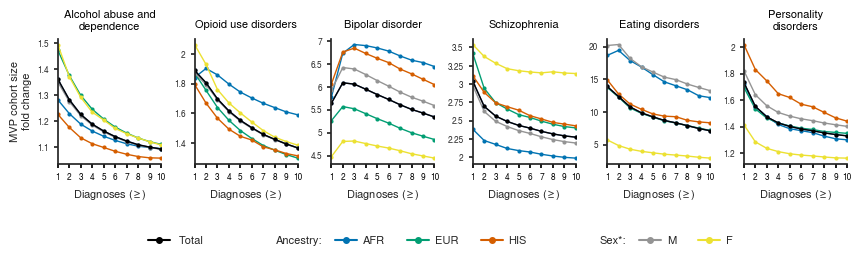

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import matplotlib.ticker as mtick
import matplotlib.lines as mlines

# ---------- PARAMS ----------
SET_X          = "X"
SET_EXTENDED   = "R2_or_R1"

formatter = EngFormatter(sep="")

# ADD "All"
ROW_DEMOS = ["Hare", "Sex", "All"]
ROW_LABELS = {"Hare": "Ancestry", "Sex": "Sex", "All": "All"}

# Use seaborn colorblind palette
base_palette = sns.color_palette("colorblind")

PALETTES = {
    "Hare": dict(zip(["AFR", "EUR", "HIS"], [base_palette[0]] + base_palette[2:4])),
    "Sex": dict(zip(["M", "F"], base_palette[7:9])),
    "All": dict(zip(["All"], 'black'))
}

# ---------- PREPARE FIGURE LAYOUT ----------
some_demo = ROW_DEMOS[0]
phecodes = sorted(demo_dfs[some_demo]["Phecode"].unique())
dx_values = sorted(demo_dfs[some_demo]["DxCount"].unique())[:10]

n_cols = len(phecodes)
fig, axes = plt.subplots(
    1, n_cols,
    figsize=(8.5, 2),
    constrained_layout=True,
    sharex="col"
)
axes = np.atleast_1d(axes)

# ---------- MAIN LOOP ----------
# Precompute fold changes for both demographics
fold_all = []
for demo_choice in ROW_DEMOS:
    df_demo = demo_dfs[demo_choice].copy()
    key_col = demo_choice

    for phe in phecodes:
        sub = df_demo[df_demo["Phecode"] == phe]
        for lvl in sorted(sub[key_col].dropna().unique()):
            sub_lvl = sub[sub[key_col] == lvl]
            for dx in dx_values:
                sub_dx = sub_lvl[sub_lvl["DxCount"] == dx]
                x_n   = sub_dx.loc[sub_dx["Set"] == SET_X, "CStat"].sum()
                ext_n = sub_dx.loc[sub_dx["Set"] == SET_EXTENDED, "CStat"].sum()
                fold_ext = ext_n / x_n if x_n > 0 else np.nan
                fold_all.append((phe, demo_choice, lvl, dx, fold_ext))

fold_df = pd.DataFrame(
    fold_all,
    columns=["phecode", "demo", "level", "DxCount", "FoldChange"]
)

### NEW: compute overall mean per-phecode & per-DxCount
overall_df = fold_df[fold_df["demo"] == "All"].copy()

# ---------- PLOT ----------
for c, phe in enumerate(phecodes):
    ax = axes[c]
    sub_phe = fold_df[fold_df["phecode"] == phe]

    # existing subgroup curves
    for demo_choice in ROW_DEMOS:
        sub_demo = sub_phe[sub_phe["demo"] == demo_choice]
        palette = PALETTES[demo_choice]
        for lvl, grp in sub_demo.groupby("level"):
            sns.lineplot(
                data=grp,
                x="DxCount", y="FoldChange",
                marker="o", linewidth=1, markersize=3,
                markeredgewidth=0, ax=ax,
                color=palette.get(lvl, "gray"),
                label=f"{ROW_LABELS[demo_choice]}: {lvl}"
            )

    ### NEW: add black overall curve
    sub_overall = overall_df[overall_df["phecode"] == phe]
    sns.lineplot(
        data=sub_overall,
        x="DxCount", y="FoldChange",
        color="black",
        linewidth=1,
        marker="o",
        markersize=3,
        markeredgewidth=0,
        ax=ax,
        label="Total"
    )

    # Axis formatting (unchanged)
    ax.tick_params(axis="x", colors="black")
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mtick.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mtick.NullLocator())
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    ax.set_xlim(dx_values[0], dx_values[-1])
    ax.set_xlabel(r"Diagnoses ($\geq$)")
    ax.set_ylabel("MVP cohort size\nfold change" if c == 0 else "")

    import textwrap
    phe_str = phecode_info.loc[phecode_info["phecode"] == phe, "phecode_string"].squeeze()
    wrapped_title = "\n".join(textwrap.wrap(phe_str, width=20))
    ax.set_title(
        wrapped_title,
        size=8,
        color="black",
        pad=8,
        wrap=True
    )

# ---------- LEGENDS ----------
# Remove subplot legends
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Build legend handles separately
handles_ancestry = [
    mlines.Line2D([], [], color=col, marker="o", markersize=4, label=lvl)
    for lvl, col in PALETTES["Hare"].items()
]
handles_sex = [
    mlines.Line2D([], [], color=col, marker="o", markersize=4, label=lvl)
    for lvl, col in PALETTES["Sex"].items()
]
### NEW: overall legend entry
handles_overall = [
    mlines.Line2D([], [], color="black", marker="o", markersize=4, label="Total")
]

offset = 0.15
leg3 = fig.legend(
    handles=handles_overall,
    loc="lower center",
    bbox_to_anchor=(0.2, -0.25),
    ncol=1,
    frameon=False,
    columnspacing=2,
)

leg1 = fig.legend(
    handles=handles_ancestry,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    frameon=False,
    handletextpad=0.5,
    columnspacing=2,
)

leg2 = fig.legend(
    handles=handles_sex,
    loc="lower center",
    bbox_to_anchor=(0.8, -0.25),
    ncol=2,
    frameon=False,
    handletextpad=0.5,
    columnspacing=2,
)


# plt.setp(leg1.get_title(), fontweight="bold")
# plt.setp(leg2.get_title(), fontweight="bold")

fig.canvas.draw()

for label, leg in [
    ("Ancestry:", leg1),
    ("Sex*:", leg2),
    ("", leg3)
]:
    bbox = leg.get_window_extent().transformed(fig.transFigure.inverted())
    fig.text(
        bbox.x0 - 0.01,
        (bbox.y0 + bbox.y1) / 2,
        label,
        ha="right",
        va="center",
        # weight="bold",
    )

# ax.set_title("MVP cohort size change across\n neuropsychiatric phenotypes vs PhecodeX", fontsize=8)

# ---------- SAVE ----------
for ext in ['png', 'svg']:
    fig.savefig(f"../figures/fig6.{ext}", dpi=300, bbox_inches='tight')

plt.show()


In [38]:
fold_df[(fold_df['phecode']=='MB_296')&fold_df['level'].isin(['HIS'])]['FoldChange'].min()

np.float64(2.4272076372315037)

In [42]:
fold_df[fold_df['phecode']=='MB_280.2']['FoldChange'].min()

np.float64(1.300847936687394)

In [ ]:
fold_df.to_csv('extended.csv')

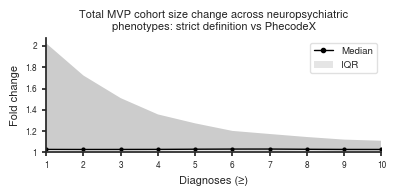

In [54]:
from matplotlib.ticker import EngFormatter
import matplotlib.lines as mlines
from matplotlib.patches import Patch

# ---------- PARAMS ----------
SET_X        = "X"
SET_R2       = "R2"        # strict definition (R★ only)
ROW_DEMOS = ["Hare", "Sex"]
formatter = EngFormatter(sep="")

# choose reference demo for ordering
some_demo = ROW_DEMOS[0]
phecodes  = sorted(demo_dfs[some_demo]["Phecode"].unique())
dx_values = sorted(demo_dfs[some_demo]["DxCount"].unique())[:10]

# ============================================================
#       BUILD LONG-FORMAT strict fold-change DATAFRAME
# ============================================================
rows = []

for demo_choice in ROW_DEMOS:
    df_demo = demo_dfs[demo_choice].copy()
    key_col = demo_choice

    for phe in phecodes:
        sub = df_demo[df_demo["Phecode"] == phe]

        levels = sorted(sub[key_col].dropna().unique())
        for lvl in levels:
            sub_lvl = sub[sub[key_col] == lvl]

            for dx in dx_values:
                sub_dx = sub_lvl[sub_lvl["DxCount"] == dx]

                x_n  = sub_dx.loc[sub_dx["Set"] == SET_X, "CStat"].sum()
                r2_n = sub_dx.loc[sub_dx["Set"] == SET_R2, "CStat"].sum()

                fold = r2_n / x_n if x_n > 0 else np.nan

                rows.append((phe, dx, demo_choice, lvl, fold))

# long-format dataset
fold_df_long = pd.DataFrame(
    rows, columns=["phecode", "DxCount", "demo", "level", "FoldChange"]
)

# ============================================================
#       NO grouping — seaborn computes median + IQR
# ============================================================
overall_df = fold_df_long.copy()

# ============================================================
#               PLOT (median + IQR)
# ============================================================
fig, ax = plt.subplots(figsize=(4, 2.0))

sns.lineplot(
    data=overall_df,
    x="DxCount",
    y="FoldChange",
    errorbar=("pi", 50),                         # IQR shading
    err_kws={"alpha": 0.2, "edgecolor": "none"}, # light band, no outline
    estimator="median",
    color="black",
    marker="o",
    markeredgewidth=0,
    linewidth=1,
    markersize=3,
    ax=ax,
)

# Median line handle
h_median = mlines.Line2D(
    [], [], color="black", marker="o", linewidth=1, markersize=3,
    label="Median"
)

# IQR shading handle
h_iqr = Patch(
    facecolor="0.5", alpha=0.2, edgecolor="none",
    label="IQR"
)

ax.legend(
    handles=[h_median, h_iqr],
    loc="upper right",
    frameon=True,
    fontsize=7,
    framealpha=0.6,
)

ax.set_xlabel("Diagnoses (≥)")
ax.set_ylabel("Fold change")
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mtick.MultipleLocator(1))
ax.set_xlim(dx_values[0], dx_values[-1])
ax.set_ylim(1)

# ---------- UPDATED TITLE FOR STRICT ----------
ax.set_title(
    "Total MVP cohort size change across neuropsychiatric\n"
    "phenotypes: strict definition vs PhecodeX",
    fontsize=8
)

fig.tight_layout()

# ---------- SAVE ----------
for ext in ['png', 'svg']:
    fig.savefig(f"../figures/sm_fig2b.{ext}", dpi=300, bbox_inches='tight')

plt.show()


In [55]:
overall_df["FoldChange"].median()

np.float64(1.0289498972601234)

In [56]:
overall_df["FoldChange"].quantile(0.75)

np.float64(1.372013588884908)

In [57]:
overall_df["FoldChange"].quantile(0.25)

np.float64(1.0171751952681378)

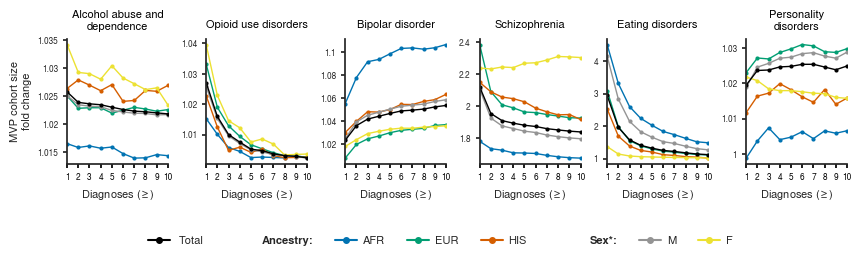

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import textwrap

# ---------- PARAMS ----------
SET_X          = "X"
SET_R2         = "R2"             # strict reviewer set (R★)
SET_R1         = "R1"
SET_EXTENDED   = "R2_or_R1"

formatter = EngFormatter(sep="")

# ADD "All" HERE
ROW_DEMOS = ["Hare", "Sex", "All"]
ROW_LABELS = {
    "Hare": "Ancestry",
    "Sex": "Sex assigned at birth",
    "All": "All (M+F)"
}

# Use seaborn colorblind palette
base_palette = sns.color_palette("colorblind")

PALETTES = {
    "Hare": dict(zip(["AFR", "EUR", "HIS"], [base_palette[0]] + base_palette[2:4])),
    "Sex": dict(zip(["M", "F"], base_palette[7:9])),
    "All": {"All": "black"}              # NEW BLACK LINE
}

# ---------- PREPARE FIGURE LAYOUT ----------
some_demo = "Hare"
phecodes = sorted(demo_dfs[some_demo]["Phecode"].unique())
dx_values = sorted(demo_dfs[some_demo]["DxCount"].unique())[:10]

n_cols = len(phecodes)
fig, axes = plt.subplots(
    1, n_cols,
    figsize=(8.5, 2),
    constrained_layout=True,
    sharex="col"
)
axes = np.atleast_1d(axes)

# ---------- MAIN LOOP ----------
fold_all = []
for demo_choice in ROW_DEMOS:
    df_demo = demo_dfs[demo_choice].copy()
    key_col = demo_choice

    for phe in phecodes:
        sub = df_demo[df_demo["Phecode"] == phe]
        for lvl in sorted(sub[key_col].dropna().unique()):
            sub_lvl = sub[sub[key_col] == lvl]
            for dx in dx_values:
                sub_dx = sub_lvl[sub_lvl["DxCount"] == dx]

                x_n  = sub_dx.loc[sub_dx["Set"] == SET_X,  "CStat"].sum()
                r2_n = sub_dx.loc[sub_dx["Set"] == SET_R2, "CStat"].sum()

                fold_r2 = r2_n / x_n if x_n > 0 else np.nan
                fold_all.append((phe, demo_choice, lvl, dx, fold_r2))

fold_df = pd.DataFrame(
    fold_all,
    columns=["phecode", "demo", "level", "DxCount", "FoldChange"]
)

# ---------- PLOT ----------
for c, phe in enumerate(phecodes):
    ax = axes[c]
    sub_phe = fold_df[fold_df["phecode"] == phe]

    for demo_choice in ROW_DEMOS:
        sub_demo = sub_phe[sub_phe["demo"] == demo_choice]
        palette = PALETTES[demo_choice]

        for lvl, grp in sub_demo.groupby("level"):
            sns.lineplot(
                data=grp,
                x="DxCount", y="FoldChange",
                marker="o", linewidth=1, markersize=3,
                markeredgewidth=0, ax=ax,
                color=palette.get(lvl, "gray"),
                label=f"{ROW_LABELS[demo_choice]}: {lvl}"
            )

    # Axis formatting
    ax.tick_params(axis="x", colors="black")
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mtick.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mtick.NullLocator())
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    ax.set_xlim(dx_values[0], dx_values[-1])
    ax.set_xlabel(r"Diagnoses ($\geq$)")
    ax.set_ylabel("MVP cohort size\nfold change" if c == 0 else "")

    # Wrapped title
    phe_str = phecode_info.loc[phecode_info["phecode"] == phe, "phecode_string"].squeeze()
    wrapped_title = "\n".join(textwrap.wrap(str(phe_str), width=20))
    ax.set_title(wrapped_title, size=8, color="black", pad=8, wrap=True)

# ---------- LEGENDS ----------
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

handles_ancestry = [
    mlines.Line2D([], [], color=col, marker="o", markersize=4, label=lvl)
    for lvl, col in PALETTES["Hare"].items()
]
handles_sex = [
    mlines.Line2D([], [], color=col, marker="o", markersize=4, label=lvl)
    for lvl, col in PALETTES["Sex"].items()
]
# NEW: overall combined (All)
handles_all = [
    mlines.Line2D([], [], color="black", marker="o", markersize=4, label="All (M+F)")
]

offset = 0.15
leg3 = fig.legend(
    handles=handles_overall,
    loc="lower center",
    bbox_to_anchor=(0.2, -0.25),
    ncol=1,
    frameon=False,
    columnspacing=2,
)

leg1 = fig.legend(
    handles=handles_ancestry,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    frameon=False,
    handletextpad=0.5,
    columnspacing=2,
)

leg2 = fig.legend(
    handles=handles_sex,
    loc="lower center",
    bbox_to_anchor=(0.8, -0.25),
    ncol=2,
    frameon=False,
    handletextpad=0.5,
    columnspacing=2,
)

fig.canvas.draw()

for label, leg in [
    ("", leg3),
    ("Ancestry:", leg1),
    ("Sex*:", leg2)
]:
    bbox = leg.get_window_extent().transformed(fig.transFigure.inverted())
    fig.text(
        bbox.x0 - 0.02,
        (bbox.y0 + bbox.y1) / 2,
        label,
        ha="right",
        va="center",
        weight="bold",
    )

# ---------- SAVE ----------
for ext in ['png', 'svg']:
    fig.savefig(f"../figures/sm_fig3.{ext}", dpi=300, bbox_inches='tight')

plt.show()


In [10]:
fold_df[fold_df['phecode']=='MB_293']#['FoldChange'].min()

NameError: name 'fold_df' is not defined

In [31]:
fold_df[fold_df['phecode']=='MB_287.1']['FoldChange'].max()

np.float64(2.385421817822174)

In [34]:
fold_df.to_csv('strict.csv')

# Supplementary Figure 1

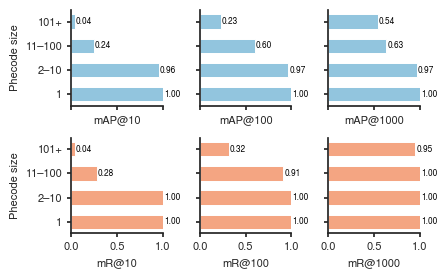

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric_dict = {"Recall": "R@k", "AP": "AP@k"}
best_model = "Qwen3-Embedding-4B"

metrics_best = master_metrics_df[master_metrics_df["model"] == best_model].copy()

# --- log-scale bins ---
max_n_gold_pos = metrics_best['n_gold_pos'].max()
bins = [0, 1, 10, 100, max_n_gold_pos]
labels = [r"1", r"2–10", r"11–100", rf"101+"]
metrics_best["icd_bin"] = pd.cut(metrics_best["n_gold_pos"], bins=bins, labels=labels, right=True)

# top row = AP, bottom row = Recall
plots = [
    ("AP", 10),
    ("AP", 100),
    ("AP", 1000),
    ("Recall", 10),
    ("Recall", 100),
    ("Recall", 1000),
]

# ───────────────────────────── 2×3 subplots ───────────────────────────── #
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(4.75, 3),
    sharex=True, sharey=True
)
axes = axes.flatten()

for i, (ax, (metric, k)) in enumerate(zip(axes, plots)):
    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = f"{metric_caps}@{k}"
    df_temp = metrics_best[metrics_best["k"] == k]

    medians = (
        df_temp.groupby("icd_bin", observed=True)[metric_dict[metric]]
        .median()
        .sort_index()
    )

    bins_order = medians.index.tolist()
    values = medians.values
    color = "#92c5de" if metric == "AP" else "#f4a582"

    ax.barh(
        bins_order, values,
        color=color, edgecolor="white", linewidth=0.7, height=0.6
    )

    for y, val in zip(bins_order, values):
        ax.text(val + 0.01, y, f"{val:.2f}",
                va="center", ha="left", fontsize=6, color="black")

    ax.set_xlim(0, 1)
    ax.set_xlabel(f"m{metric_k}", fontsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

    # y-labels only on left column
    if i % 3 == 0:
        ax.set_ylabel("Phecode size", fontsize=8)
    else:
        ax.set_ylabel("")
        ax.tick_params(axis="y", labelleft=False)

plt.tight_layout(rect=[0.05, 0.06, 1, 1])

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/sm_fig1a.{ext}", dpi=300)
plt.show()


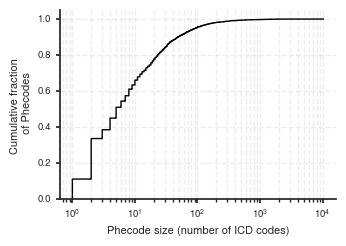

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# assuming master_metrics_df exists
# extract unique phecodes and their ICD counts
phecode_icd_counts = (
    master_metrics_df[["phecode", "n_gold_pos"]]
    .drop_duplicates(subset="phecode")
    .set_index("phecode")["n_gold_pos"]
)

# sort ascending
sorted_counts = np.sort(phecode_icd_counts)
n = len(sorted_counts)
cdf = np.arange(1, n + 1) / n  # cumulative fraction of phecodes

# plot
plt.figure(figsize=(3.5, 2.5))
plt.plot(sorted_counts, cdf, drawstyle="steps-post", lw=1, color="black")

plt.xscale("log")
plt.xlabel("Phecode size (number of ICD codes)", fontsize=8)
plt.ylabel("Cumulative fraction \n of Phecodes", fontsize=8)
plt.tick_params(axis="x", labelsize=7)
plt.tick_params(axis="y", labelsize=7)
plt.ylim(0)

plt.grid(True, which="both", linestyle="--", alpha=0.4, color='lightgray')
plt.tight_layout()

# save
for extension in ['png', 'svg']:
    plt.savefig(f"../figures/sm_fig1b.{extension}", dpi=300)


In [76]:
n_total = len(phecode_icd_counts)
n_small = (phecode_icd_counts <= 10).sum()
frac_small = n_small / n_total
n_large = (1 - frac_small) * n_total

In [75]:
frac_small

np.float64(0.6603298853788091)

In [77]:
n_large

np.float64(1214.9999999999998)

In [79]:
# Restrict to "complex" Phecodes with >10 ICD codes
complex_phecodes = phecode_icd_counts[phecode_icd_counts > 10]

# Compute median and IQR
median_complex = complex_phecodes.median()
q1_complex = complex_phecodes.quantile(0.25)
q3_complex = complex_phecodes.quantile(0.75)

print(f"Complex Phecodes (n={len(complex_phecodes)}): "
      f"median size = {median_complex:.1f} (IQR: {q1_complex:.1f}–{q3_complex:.1f})")



Complex Phecodes (n=1215): median size = 28.0 (IQR: 18.0–59.0)


# old code

In [ ]:
# old code

In [ ]:


xls = pd.ExcelFile("/sc/arion/projects/va-biobank/jamie/phecoder/validation/phecoder_validation_ST_final_annotated.xlsx")
# --- prepare a dict to hold updated sheets ---
updated_sheets = {}

for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name, dtype={"icd_code": str})

    df['icd_code'] = df['icd_code'].astype("string[python]")
    df["icd_code"] = df["icd_code"].str.replace(r"\.$", "", regex=True)
    df['icd_string'] = df['icd_string'].astype("string[python]")

    # merge on icd_code and icd_string
    merged = df.drop(columns=['flag'], errors='ignore').merge(
        icd_info[['icd_code', 'icd_string', 'flag']],
        on=['icd_code', 'icd_string'],
        how='left',  # keeps all rows from df
    )

    updated_sheets[sheet_name] = merged
with pd.ExcelWriter("/sc/arion/projects/va-biobank/jamie/phecoder/validation/phecoder_validation_ST_final_annotated_fixed.xlsx") as writer:
    for name, data in updated_sheets.items():
        data.to_excel(writer, sheet_name=name, index=False)
- Load results for ensemble.
- Merge annotations on 'icd_code, icd_string'.
- Add 
annotations_all.columns
sim_df.merge(annotations_all, on=['phecode', 'icd_code', 'icd_string'], how='left')
df = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/icd_info_new.parquet')

# Old code

get current annotations

In [96]:
# Load all sheets into a dict
annotations_dict = pd.read_excel(
    "/sc/arion/projects/va-biobank/jamie/phecoder/validation/phecoder_validation_ST_2.xlsx",
    sheet_name=None,
    dtype={"icd_code": str}
)

frames = []

for sheet_name, df in annotations_dict.items():
    # Extract phecode inside brackets, e.g. "Eating disorders (MB_293)" → "MB_293"
    m = re.search(r"\((.*?)\)", sheet_name)
    phecode = m.group(1) if m else None
    # Add as a column
    df = df.copy()
    df["phecode"] = phecode
    
    frames.append(df)

# Concatenate into one long DataFrame
annotations_all = pd.concat(frames, ignore_index=True)

get 50% ppv ranks

In [97]:
metrics = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/results/case_studies/metrics.parquet')
pr_curves = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/results/case_studies/pr_curves.parquet')

threshold = 0.5
ppv_df = []

for _, row in pr_curves.iterrows():
    model = row["model"]
    phecode = row["phecode"]
    precisions = row["curve_precision"]

    # find first index >= 11 where precision < threshold
    cutoff_idx = next(
        (i for i, p in enumerate(precisions, start=1) if i > 10 and p < threshold),
        None
    )

    ppv_df.append({
        "model": model,
        "phecode": phecode,
        "cutoff_rank": cutoff_idx
    })

ppv_df = pd.DataFrame(ppv_df)


load recs and apply 50% ppv cut off

In [98]:
rec_files = glob.glob("/sc/arion/projects/va-biobank/jamie/phecoder/results/case_studies/**/similarity.parquet", recursive=True)
recs = pd.concat(pd.read_parquet(file) for file in rec_files)

# Merge cutoffs into recs
recs_cut = recs.merge(ppv_df, on=["model", "phecode"], how="left")

# Keep only rows up to cutoff (or all if cutoff is None)
recs_truncated = recs_cut[
    recs_cut["cutoff_rank"].isna() | (recs_cut["rank"] < recs_cut["cutoff_rank"])
].copy()

# Drop helper column if you don’t want it
recs_truncated = recs_truncated.drop(columns=["cutoff_rank"])

In [60]:
test = recs_truncated
models = [
    "Alibaba-NLP/gte-Qwen2-7B-instruct", # best model on MTEB leaderboard (Medical)
    "infly/inf-retriever-v1", # best model on MTEB leaderboard (Medical) for information retrieval
    "all-MiniLM-L6-v2", # original SentenceTransformer model: best across all datasets tested. No clinical motivation (train or evaluation)
    "sentence-t5-xxl",  # original SentenceTransformer model: tuned for sentence embedding task. No clinical motivation (train or evaluation)
    "multi-qa-mpnet-base-dot-v1", # original SentenceTransformer model: tuned for semantic search task. No clinical motivation (train or evaluation)
    "NeuML/pubmedbert-base-embeddings",  # trained on PubMed
    "FremyCompany/BioLORD-2023",  # model trained specifically on clinical sentences and biomedical concepts
]
test = test[test['model'].isin(models)]
# test = test[test['phecode']=='MB_280.11']

In [61]:
phecode_icd_lookup = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_icd_pairs.parquet')

In [62]:
len(test[['icd_code', 'icd_string']].drop_duplicates())

630

In [63]:
len(set(test['icd_code'].drop_duplicates().tolist()) | set(phecode_icd_lookup[phecode_icd_lookup['phecode']=='MB_280.11']['icd_code'].tolist()))

644

create new validation df to be annotated 

In [64]:
# recs_truncated = test

In [99]:
# Universe of pairs from recs
pairs = recs_truncated[['phecode', 'icd_code', 'icd_string']].drop_duplicates()

# Merge annotations (keeping only one row per pair)
annotations_dedup = annotations_all.drop_duplicates(subset=['phecode','icd_code'])

phecoder_validation_2 = pairs.merge(
    annotations_dedup,
    on=['phecode','icd_code'],
    how='left',
    suffixes=('', '_annot')
)
phecoder_validation_2 = phecoder_validation_2.drop('icd_string_annot', axis=1)
print(len(phecoder_validation_2), len(pairs))

1118 1118


In [72]:
phecoder_validation_2[phecoder_validation_2['relevant'].isna()].head(60)

,phecode,icd_code,icd_string,flag,relevant,comments
30,MB_280.11,G31.2,Degeneration of nervous system due to alcohol,NaN,NaN,NaN
33,MB_280.11,F11.23,Opioid dependence with withdrawal,NaN,NaN,NaN
38,MB_280.11,571.2,ALCOHOLIC CIRRHOSIS OF LIVER,NaN,NaN,NaN
39,MB_280.11,357.5,ALCOHOLIC POLYNEUROPATHY,NaN,NaN,NaN
40,MB_280.11,G62.1,Alcoholic polyneuropathy,NaN,NaN,NaN
42,MB_280.11,K70.2,Alcoholic fibrosis and sclerosis of liver,NaN,NaN,NaN
44,MB_280.11,K86.0,Alcohol-induced chronic pancreatitis,NaN,NaN,NaN
45,MB_280.11,K70.0,Alcoholic fatty liver,NaN,NaN,NaN
51,MB_280.11,F11.13,Opioid abuse with withdrawal,NaN,NaN,NaN
55,MB_280.11,G72.1,Alcoholic myopathy,NaN,NaN,NaN


In [100]:
# Choose column that defines the sheets
split_col = "category"

# Save to Excel, each sheet = one category
output_file = "output.xlsx"
with pd.ExcelWriter(output_file) as writer:
    for key, sub_df in phecoder_validation_2.groupby('phecode'):
        # Excel sheet names must be <= 31 chars and not contain [ ] : * ? / \
        safe_key = str(key)
        df = sub_df.sort_values('relevant', ascending=True)
        df.to_excel(writer, sheet_name=safe_key, index=False)


In [25]:
annotations_dedup[annotations_dedup['icd_code']=='994.2']

,icd_code,icd_string,flag,relevant,comments,phecode
37,994.2,EFFECTS OF HUNGER,9,1,can occur in severe AN,MB_293


Idea for plot. Plot correlation between similarity scores (top_100 maybe top_1000)

In [123]:
model = 'infly/inf-retriever-v1'
# model = 'FremyCompany/BioLORD-2023'
phecode = 'MB_286.1'

pr_curve_example = pr_curves[(pr_curves['phecode']==phecode)&(pr_curves['model']==model)]
precision = pr_curve_example['curve_precision'].iat[0]
recall = pr_curve_example['curve_recall'].iat[0]

metrics_example = metrics[(metrics['phecode']==phecode)&(metrics['model']==model)]

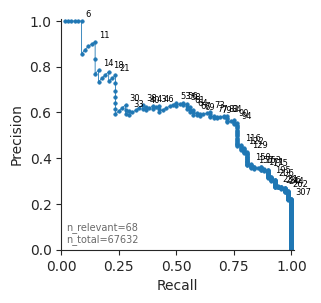

In [122]:
import numpy as np
import matplotlib.pyplot as plt

pr_curve_example = pr_curves[
    (pr_curves['phecode'] == phecode) & (pr_curves['model'] == model)
]
precision = np.array(pr_curve_example['curve_precision'].iat[0])
recall    = np.array(pr_curve_example['curve_recall'].iat[0])

# grab gold count from metrics_example
n_gold = metrics_example['n_gold_pos'].iat[0]
n_considered = metrics_example['n_considered'].iat[0]

plt.figure(figsize=(3,3))
plt.plot(
    recall, 
    precision, 
    marker="o", 
    markersize=2.5, 
    markeredgewidth=0.5, 
    linewidth=0.6, 
    label="PR curve"
)

# --- annotate edges (first index before each downward run) ---
drops = np.where(np.diff(precision) < 0)[0]
edge_idx = drops[np.insert(np.diff(drops) > 1, 0, True)]
for i in edge_idx:
    if precision[i] > 0.0:
        rank = i + 1
        plt.annotate(
            f"{rank}",
            (recall[i], precision[i]),
            textcoords="offset points",
            xytext=(3,3),
            fontsize=6,
            color="black"
        )

# --- overlay total ground truth count ---
plt.text(
    0.02, 0.02, 
    f"n_relevant={n_gold}\nn_total={n_considered}", 
    transform=plt.gca().transAxes,
    ha="left", va="bottom", fontsize=7, color="dimgray"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.show()


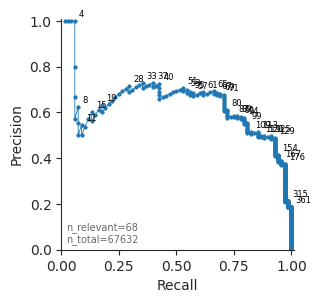

In [124]:
import numpy as np
import matplotlib.pyplot as plt

pr_curve_example = pr_curves[
    (pr_curves['phecode'] == phecode) & (pr_curves['model'] == model)
]
precision = np.array(pr_curve_example['curve_precision'].iat[0])
recall    = np.array(pr_curve_example['curve_recall'].iat[0])

# grab gold count from metrics_example
n_gold = metrics_example['n_gold_pos'].iat[0]
n_considered = metrics_example['n_considered'].iat[0]

plt.figure(figsize=(3,3))
plt.plot(
    recall, 
    precision, 
    marker="o", 
    markersize=2.5, 
    markeredgewidth=0.5, 
    linewidth=0.6, 
    label="PR curve"
)

# --- annotate edges (first index before each downward run) ---
drops = np.where(np.diff(precision) < 0)[0]
edge_idx = drops[np.insert(np.diff(drops) > 1, 0, True)]
for i in edge_idx:
    if precision[i] > 0.0:
        rank = i + 1
        plt.annotate(
            f"{rank}",
            (recall[i], precision[i]),
            textcoords="offset points",
            xytext=(3,3),
            fontsize=6,
            color="black"
        )

# --- overlay total ground truth count ---
plt.text(
    0.02, 0.02, 
    f"n_relevant={n_gold}\nn_total={n_considered}", 
    transform=plt.gca().transAxes,
    ha="left", va="bottom", fontsize=7, color="dimgray"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.show()


In [14]:
phecode_ground_truth = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_icd_pairs.parquet')
icd_df = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/icd_info.parquet')

In [15]:
phecode_ground_truth_trunc = phecode_ground_truth[phecode_ground_truth['icd_code'].isin(icd_df['icd_code'])]

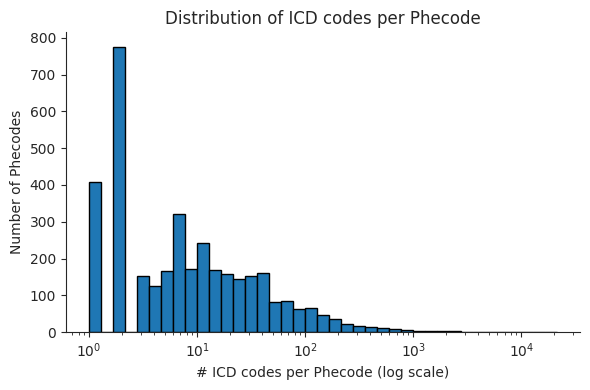

In [39]:
import matplotlib.pyplot as plt
import numpy as np

icd_counts = phecode_ground_truth.value_counts('phecode')

plt.figure(figsize=(6,4))

# Choose log-spaced bins: e.g. 1, 2, 5, 10, 20, 50, 100, ...
bins = np.logspace(
    np.log10(icd_counts.min()), 
    np.log10(icd_counts.max()), 
    40  # number of bins (adjust if needed)
)

plt.hist(icd_counts, bins=bins, edgecolor="black")
plt.xscale("log")  # 👈 log-scale x-axis

plt.title("Distribution of ICD codes per Phecode")
plt.xlabel("# ICD codes per Phecode (log scale)")
plt.ylabel("Number of Phecodes")
plt.tight_layout()
plt.show()


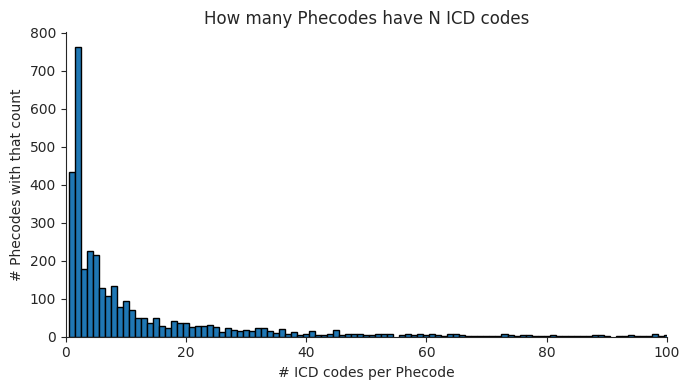

In [32]:
import matplotlib.pyplot as plt

# Get frequency of each count value
freq = icd_counts.value_counts().sort_index()

plt.figure(figsize=(7,4))
plt.bar(freq.index, freq.values, width=1, edgecolor='black')
plt.xlabel("# ICD codes per Phecode")
plt.ylabel("# Phecodes with that count")
plt.title("How many Phecodes have N ICD codes")
# plt.yscale("log")  # optional if there's a huge left spike
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

In [40]:
n_over_10 = (icd_counts > 10).sum()

In [41]:
n_over_10

np.int64(1398)

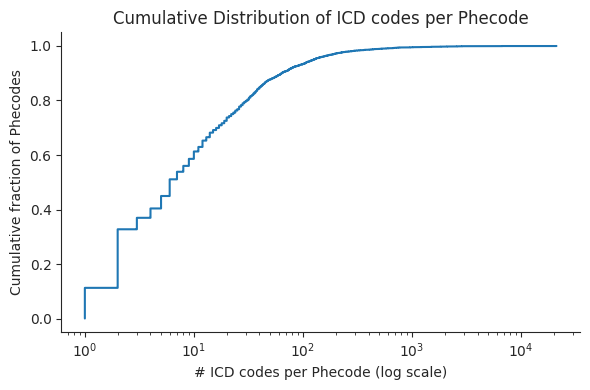

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# sort counts ascending
sorted_counts = np.sort(icd_counts)
n = len(sorted_counts)
cdf = np.arange(1, n + 1) / n  # cumulative fraction of phecodes

plt.figure(figsize=(6,4))
plt.plot(sorted_counts, cdf, drawstyle="steps-post")
plt.xscale("log")
plt.xlabel("# ICD codes per Phecode (log scale)")
plt.ylabel("Cumulative fraction of Phecodes")
plt.title("Cumulative Distribution of ICD codes per Phecode")

plt.tight_layout()
plt.show()


In [3]:
from phecoder import Phecoder
from phecoder.utils import list_runs, load_data

/sc/arion/projects/va-biobank/jamie/phecoder/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'utils'

In [112]:
import pandas as pd

def load_annotations_with_phecode(path: str) -> pd.DataFrame:
    """
    Load multi-sheet annotation Excel file into a single DataFrame.
    Assumes each sheet has columns ['phecode', 'icd_code', 'icd_string'].
    """
    annotations_dict = pd.read_excel(
        path, sheet_name=None,
        dtype={"icd_code": str, "phecode": str, "icd_string": str}
    )
    frames = []

    for sheet_name, df in annotations_dict.items():
        df = df.copy()
        # keep only expected columns if they exist
        keep_cols = [col for col in ["phecode", "icd_code", "icd_string"] if col in df.columns]
        if not keep_cols:
            continue
        frames.append(df[keep_cols])

    return pd.concat(frames, ignore_index=True).drop_duplicates()


# --- Load both versions ---
annotations_v1 = load_annotations_with_phecode(
    "/sc/arion/projects/va-biobank/jamie/phecoder/validation/phecoder_validation_ST_2.xlsx"
)
annotations_v2 = load_annotations_with_phecode(
    "/sc/arion/projects/va-biobank/jamie/phecoder/notebooks/output.xlsx"
)

# --- Compare the two ---
key_cols = ["phecode", "icd_code"]  # used for matching
new_rows = (
    annotations_v2
    .merge(annotations_v1[key_cols], on=key_cols, how="left", indicator=True)
    .query("_merge == 'left_only'")
    .drop(columns="_merge")
)

print(f"New ICD mappings found: {len(new_rows)}")



New ICD mappings found: 9


In [114]:
new_rows.to_csv('output.csv')

In [109]:
annotations_v2

,phecode,icd_code
0,None,304.22
1,None,304.32
2,None,F17.213
3,None,304.30
4,None,F17.228
...,...,...
1109,None,V11.9
1114,None,309.3
1115,None,F43.24
1116,None,294.8


In [1]:
import os
HUGGINGFACE_PATH = "/sc/arion/projects/va-biobank/jamie/phecoder/hf-home"
os.environ['HF_HOME'] = HUGGINGFACE_PATH  # set cache dir for HF BEFORE Phecoder import
from sentence_transformers import SentenceTransformer

/sc/arion/projects/va-biobank/jamie/phecoder/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models = [
    "FremyCompany/BioLORD-2023",  # model trained specifically on clinical sentences and biomedical concepts.
    "infly/inf-retriever-v1", # best model on MTEB leaderboard (Medical) for information retrieval
    "sentence-transformers/all-MiniLM-L6-v2", # original SentenceTransformer model: best across all datasets tested. "all" models trained on all data
    "sentence-transformers/sentence-t5-xxl",  # original SentenceTransformer model: best for sentence embedding task. just trained on sentences data
    "sentence-transformers/multi-qa-mpnet-base-dot-v1", # original SentenceTransformer model: best for semantic search task. just trained on sentences data
    "sentence-transformers/all-MiniLM-L12-v2", # original SentenceTransformer model: best smaller model across both tasks
    "NeuML/pubmedbert-base-embeddings",  # trained on PubMed
    "Qwen/Qwen3-Embedding-8B", # best model on MTEB leaderboard for semantic text similarity
    "Qwen/Qwen3-Embedding-4B", # 2nd best model on MTEB leaderboard for semantic text similarity
]

In [12]:
model_temp = models[6]
print(model_temp)
model = SentenceTransformer(model_temp)
core = model._first_module().auto_model

NeuML/pubmedbert-base-embeddings


In [13]:
num_params = sum(p.numel() for p in core.parameters())
num_params_trainable = sum(p.numel() for p in core.parameters() if p.requires_grad)

print(f"Total parameters: {num_params/1e6:.2f}M")
print(f"Trainable parameters: {num_params_trainable/1e6:.2f}M")

Total parameters: 109.48M
Trainable parameters: 109.48M


In [6]:
core = list(model._modules.values())[0]  # first module
hf_model = getattr(core, "auto_model", core)  # if not auto_model, use raw

sum(p.numel() for p in hf_model.parameters())

109486464

In [7]:
print(core)

Transformer({'max_seq_length': 128, 'do_lower_case': False, 'architecture': 'MPNetModel'})
